## Masked noise attenuation

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

sys.path.append('..')

from seismicpro.batchflow import Dataset, DatasetIndex, Pipeline, B, V, F
from seismicpro.batchflow.models.tf import UNet

from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex, KNNIndex, CustomIndex,
                            seismic_plot, spectrum_plot, merge_segy_files)

from unet import u_net, conv_block

%env CUDA_VISIBLE_DEVICES=1

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


env: CUDA_VISIBLE_DEVICES=1


### Hard sigmoid model configuration

In [67]:
config = tf.ConfigProto()
graph = tf.Graph()
with graph.as_default():
    trace_in = tf.placeholder('float', shape=(None, 3000, 1), name='trace_in')
    trace_offset = tf.placeholder('float', shape=(None, 1), name='trace_offset')
    target = tf.placeholder('float', shape=(None, 3000, 1), name='target')
    balance = tf.placeholder('float', name='balance')
    balance_fft = tf.placeholder('float', name='balance_fft')
    learning_rate = tf.placeholder('float', name='learning_rate')
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    print('=====================')
    print('BUILD TRACE ATTENTION')
    print('=====================')
    with tf.variable_scope("attention_scope"):
        attention = u_net(trace_in, depth=3, filters=8, kernel_size=3,
                          activation='elu', is_training=is_training)
        attention = conv_block(attention, 'ca', filters=1, kernel_size=3,
                               activation='sigmoid')
    print('attention', attention.get_shape())

    attention_sum = tf.reduce_sum(attention, axis=1)
    print('attention_sum', attention_sum.get_shape())

    sigm_x = tf.fill(tf.shape(attention)[:2], 0.0)
    sigm_len = tf.cast(tf.shape(attention)[1], 'float')
    sigm_x = sigm_x - tf.range(0, sigm_len, dtype='float')

    attention_sigmoid = tf.sigmoid(sigm_x + attention_sum)
    attention_sigmoid = tf.expand_dims(attention_sigmoid, -1)
    print('attention_sigmoid', attention_sigmoid.get_shape())

    print('=====================')
    print('BUILD FFT ATTENTION')
    print('=====================')
    fft_trace = tf.spectral.rfft(tf.squeeze(trace_in, axis=-1))
    print('fft_trace', fft_trace.get_shape())
    fft_trace_abs = tf.cast(tf.abs(fft_trace), tf.float32)
    fft_trace_abs = tf.expand_dims(fft_trace_abs, -1)
    print('fft_trace_abs', fft_trace_abs.get_shape())

    with tf.variable_scope("fft_scope"):
        fft_attention = u_net(fft_trace_abs,
                              depth=3, filters=8, kernel_size=3,
                              activation='elu', is_training=is_training)
        fft_attention = conv_block(fft_attention, 'ca', filters=1, kernel_size=3,
                                   activation='sigmoid')
        
    fft_attention_sum = tf.reduce_sum(fft_attention, axis=1)
    print('fft_attention_sum', fft_attention_sum.get_shape())

    sigm_fft = tf.fill(tf.shape(fft_attention)[:2], 0.0)
    sigm_fft_len = tf.cast(tf.shape(fft_attention)[1], 'float')
    sigm_fft = tf.add(sigm_fft, -tf.range(0, sigm_fft_len, dtype='float'))
    
#     fft_attention_mean = -tf.reduce_mean(
#         tf.multiply(sigm_fft, tf.squeeze(fft_attention, axis=-1)), axis=1,
#         keepdims=True)
#     print('fft_attention_mean', fft_attention_mean.get_shape())
        
#     sigm_fft_1 = sigm_fft + fft_attention_sum / 2. + fft_attention_mean
#     fft_attention_sigmoid_1 = tf.sigmoid(sigm_fft_1)
    
#     sigm_fft_2 = sigm_fft - fft_attention_sum / 2. + fft_attention_mean
#     fft_attention_sigmoid_2 = tf.sigmoid(sigm_fft_2)
    
#     fft_attention_sigmoid = fft_attention_sigmoid_1 - fft_attention_sigmoid_2

    fft_attention_sigmoid = tf.sigmoid(sigm_fft + fft_attention_sum)
    
    print('fft_attention_sigmoid', fft_attention_sigmoid.get_shape())
    
    fft_attention_sigmoid = tf.cast(fft_attention_sigmoid, tf.complex64)

    fft_trace_low = tf.multiply(fft_trace, fft_attention_sigmoid)
    trace_low = tf.spectral.irfft(fft_trace_low)
    trace_low = tf.expand_dims(trace_low, -1)
    trace_low = tf.cast(trace_low, tf.float32)
    print('trace_low', trace_low.get_shape())

    fft_trace_high = tf.multiply(fft_trace, 1 - fft_attention_sigmoid)
    trace_high = tf.spectral.irfft(fft_trace_high)
    trace_high = tf.expand_dims(trace_high, -1)
    trace_high = tf.cast(trace_high, tf.float32)
    print('trace_high', trace_high.get_shape())
    
    fft_attention_sigmoid = tf.cast(fft_attention_sigmoid, tf.float32)

    print('=====================')
    print('BUILD LIFT')
    print('=====================')
    with tf.variable_scope("lift_scope"):
        lift_trace_low = u_net(trace_low, depth=5, filters=16,
                               kernel_size=7, activation='elu',
                               is_training=is_training)
        lift_trace_low = conv_block(lift_trace_low, 'c', filters=1, kernel_size=3)
    print('lift_trace_low', lift_trace_low.get_shape())
    
    lift_trace = lift_trace_low + trace_high
    
    predict = (tf.multiply(trace_in, attention_sigmoid) +
               tf.multiply(lift_trace, 1 - attention_sigmoid))

    loss = (tf.losses.absolute_difference(target, predict) 
            +
            balance * tf.reduce_mean(1 - attention_sigmoid) 
            +
            balance_fft * tf.reduce_mean(fft_attention_sigmoid)
           )

    optimizer = tf.train.AdamOptimizer(learning_rate)

    lift_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                  scope='lift_scope')
    attention_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope='attention_scope')
    fft_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                 scope='fft_scope')

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        step_attention = optimizer.minimize(loss, var_list=attention_vars)
        step_lift = optimizer.minimize(loss, var_list=lift_vars)
        step_fft = optimizer.minimize(loss, var_list=fft_vars)
    
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
#     saver.restore(sess, './demo_attention_model_H.ckpt')

BUILD TRACE ATTENTION
input (?, 3000, 1)
conv_block_0 (?, 3000, 8)
pool_0 (?, 1500, 8)
conv_block_1 (?, 1500, 16)
pool_1 (?, 750, 16)
conv_block_2 (?, 750, 32)
pool_2 (?, 375, 32)
bottom_conv_block_3 (?, 375, 64)
up_2 (?, 750, 64)
concat_3 (?, 750, 96)
up_conv_block_3 (?, 750, 32)
up_1 (?, 1500, 32)
concat_2 (?, 1500, 48)
up_conv_block_2 (?, 1500, 16)
up_0 (?, 3000, 16)
concat_1 (?, 3000, 24)
up_conv_block_1 (?, 3000, 8)
attention (?, 3000, 1)
attention_sum (?, 1)
attention_sigmoid (?, 3000, 1)
BUILD FFT ATTENTION
fft_trace (?, 1501)
fft_trace_abs (?, 1501, 1)
input (?, 1501, 1)
conv_block_0 (?, 1501, 8)
pool_0 (?, 751, 8)
conv_block_1 (?, 751, 16)
pool_1 (?, 376, 16)
conv_block_2 (?, 376, 32)
pool_2 (?, 188, 32)
bottom_conv_block_3 (?, 188, 64)
up_2 (?, 376, 64)
concat_3 (?, 376, 96)
up_conv_block_3 (?, 376, 32)
up_1 (?, ?, 32)
concat_2 (?, 751, 48)
up_conv_block_2 (?, 751, 16)
up_0 (?, ?, 16)
concat_1 (?, 1501, 24)
up_conv_block_1 (?, 1501, 8)
fft_attention_sum (?, 1)
fft_attention_s

### Index data

In [56]:
path_raw = '/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))
index.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
111906,35,1656,1,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,1,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,36,1657,2,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,2,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,78,1655,3,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,3,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,79,1658,4,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,4,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,127,1654,5,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,5,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...


### Define train set

In [57]:
tindex = TraceIndex(index.create_subset(index.indices[:10]))
train_set = Dataset(tindex, SeismicBatch)
len(train_set)

34560

### Define preprocess pipeline

In [58]:
train_pipeline = (Pipeline()
                  .load(components=('raw', 'lift'), fmt='segy',
                        tslice=np.arange(3000))
                 )
                  
train_pipeline = train_pipeline << train_set

## Run model training

In [111]:
loss_history = []
for _ in tqdm(range(300)):
    batch = train_pipeline.next_batch(batch_size=64, drop_last=True,
                                      n_enochs=None, shuffle=True)

    x = np.expand_dims(np.vstack(batch.raw), -1)
    y = np.expand_dims(np.vstack(batch.lift), -1)
    
    res = sess.run([
                    loss, 
                    step_attention,
                    step_lift,
                    step_fft
                   ],
                   feed_dict={trace_in: x,
                              target: y, 
                              is_training: True,
                              balance: 0.05,
                              balance_fft: 0.5,
                              learning_rate: 0.0001})
    loss_history.append(res[0])

100%|██████████| 300/300 [01:59<00:00,  2.52it/s]


In [54]:
# saver.save(sess, "./demo_attention_model_H.ckpt")

'./demo_attention_model_H.ckpt'

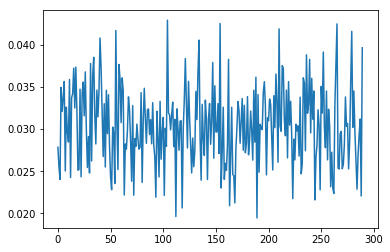

In [112]:
plt.plot(loss_history[10:])
plt.show()

## Model test

In [152]:
i = 30
test_set = Dataset(TraceIndex(index.create_subset(index.indices[i: i+1])),
                   SeismicBatch)

res_stack = []
x_stack = []
y_stack = []
batch_size = 1000

for _ in range(1 + len(test_set) // batch_size):
    batch = (test_set.next_batch(batch_size, n_epochs=1)
             .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
            )

    x = np.expand_dims(np.vstack(batch.raw), -1)
    y = np.expand_dims(np.vstack(batch.lift), -1)

    res = sess.run([attention,
                    predict,
                    lift_trace,
                    attention_sigmoid,
                    fft_attention,
                    fft_attention_sigmoid,
                   fft_trace,
                   fft_trace_low
                   ],
                   feed_dict={trace_in: x, is_training: False})

    res_stack.append(res)
    x_stack.append(x)
    y_stack.append(y)

In [155]:
att = np.squeeze(np.concatenate([t[0] for t in res_stack]))
out = np.squeeze(np.concatenate([t[1] for t in res_stack]))
out_lift = np.squeeze(np.concatenate([t[2] for t in res_stack]))
att_sigm = np.squeeze(np.concatenate([t[3] for t in res_stack]))
att_fft = np.squeeze(np.concatenate([t[4] for t in res_stack]))
att_fft_sigm = np.squeeze(np.concatenate([t[5] for t in res_stack]))
fft_t = np.squeeze(np.concatenate([t[6] for t in res_stack]))
fft_t_low = np.squeeze(np.concatenate([t[7] for t in res_stack]))
raw = np.squeeze(np.concatenate(x_stack))
lift = np.squeeze(np.concatenate(y_stack))

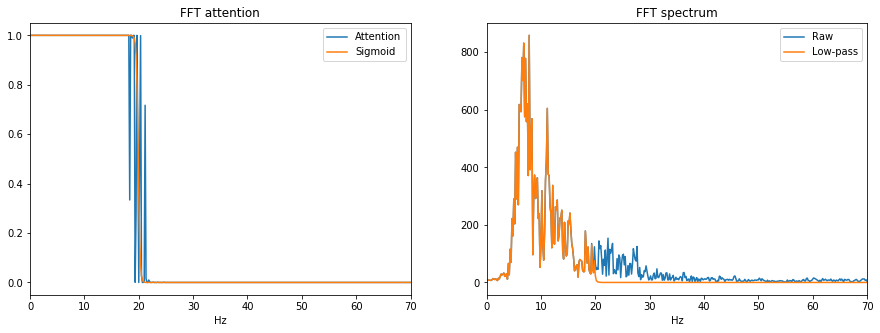

In [157]:
ff = np.fft.rfftfreq(3000, d=0.002)
i = 20
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(ff, abs(att_fft[i]), label='Attention')
ax[0].plot(ff, abs(att_fft_sigm[i]), label='Sigmoid')
ax[0].set_xlim([0, 70])
ax[0].set_xlabel('Hz'), ax[0].set_title('FFT attention')
ax[1].plot(ff, abs(fft_t[i]), label='Raw')
ax[1].plot(ff, abs(fft_t_low[i]), label='Low-pass')
ax[1].set_xlim([0, 70])
ax[1].set_xlabel('Hz'), ax[1].set_title('FFT spectrum')
ax[0].legend(), ax[1].legend()
plt.show()

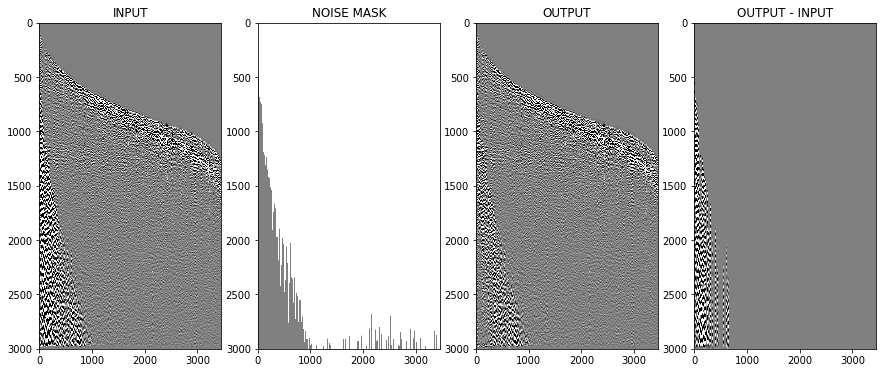

In [120]:
cv = 0.5
seismic_plot([raw, abs(att_sigm), out, -raw + out], names=['INPUT', 'NOISE MASK', 'OUTPUT', 'OUTPUT - INPUT'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

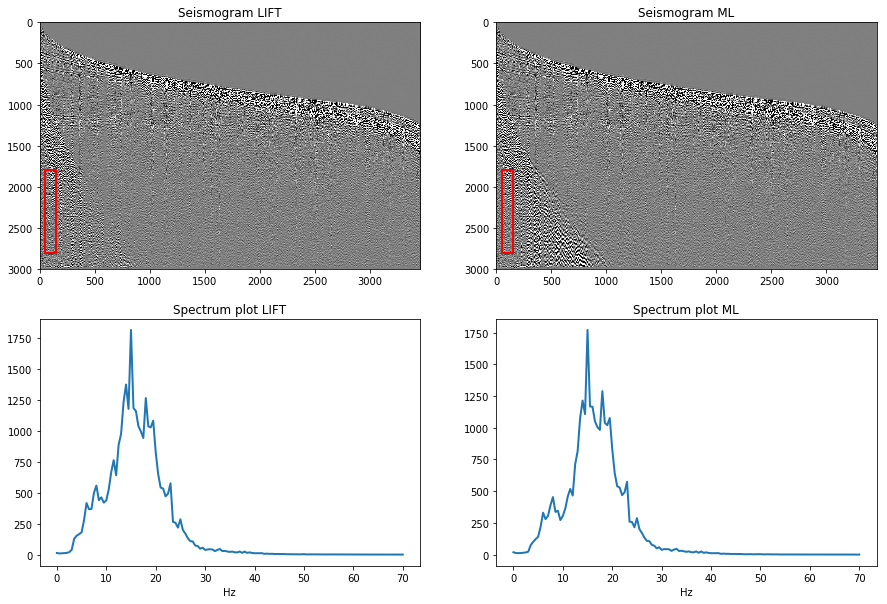

In [124]:
spectrum_plot([lift, out], names=['LIFT', 'ML'],
             frame=(slice(50, 150), slice(1800, 2800)),
                    rate=0.002, max_freq=70,
                    figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray')

### Model exploration

Here we generate single-frequency waves (sinusoidal) and investigate noise attenuation model output for these inputs.

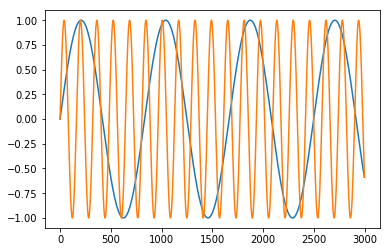

In [140]:
waves = 1. * np.array([np.sin(np.linspace(0, 12 * np.pi * k, 3000)) for k in np.arange(0.1, 100, 0.1)])
f_wave = np.arange(0.1, 100, 0.1)
plt.plot(waves[5])
plt.plot(waves[30])
plt.show()

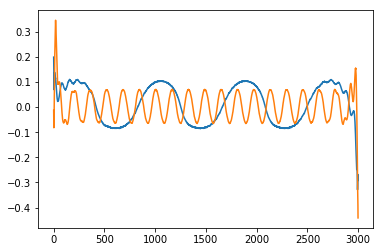

In [141]:
res = sess.run(lift_trace,
               feed_dict={trace_in: waves.reshape((-1, 3000, 1)),
                          trace_offset: np.array([0] * len(waves)).reshape((-1, 1)),
                          is_training: False})

plt.plot(np.squeeze(res[5]))
plt.plot(np.squeeze(res[30]))
plt.show()

### Singal energy before/after filtration

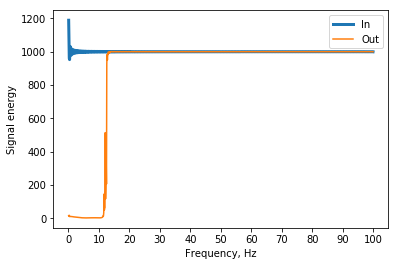

In [142]:
plt.plot(f_wave, np.sum(waves[:, 500: 2500] ** 2, axis=1), label='In', lw=3)
plt.plot(f_wave, np.sum(res[:, 500: 2500] ** 2, axis=1), label='Out')
plt.xlabel('Frequency, Hz')
plt.ylabel('Signal energy')
plt.xticks(np.arange(0, 101, 10))
plt.legend()
plt.show()

In [143]:
spec_res = abs(np.fft.rfft(res[:, 500:2500, 0], axis=1))**2
freqs = np.fft.rfftfreq(len(waves[0, 500:2500]), d=0.002)

### RMS frequency before/after filtration

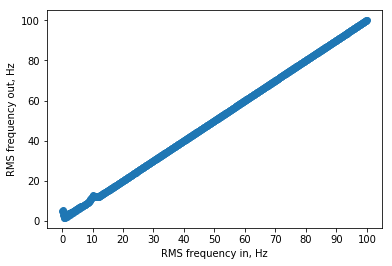

In [144]:
plt.scatter(f_wave,
            np.sqrt(np.sum(freqs**2 * spec_res, axis=1) / np.sum(spec_res, axis=1)))
plt.xlabel('RMS frequency in, Hz')
plt.ylabel('RMS frequency out, Hz')
plt.xticks(np.arange(0, 101, 10))
plt.show()